In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import regex as re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

from wordcloud import WordCloud

import joblib

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sexpe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sexpe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Importing the data

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")

In [5]:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [7]:
df.shape

(2999, 2)

In [8]:
df.drop_duplicates().shape

(2369, 2)

In [9]:
#Since there are more than 600 duplicates, lets remove them and reset the index
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
#Turning True and False into 1 and 0

df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x else 0)

In [11]:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [13]:
#Step 2: Preprocessing the links
#Tokenize, Remove stopwords, Lemmatize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [15]:
#Text processing, defining a function

import regex as re

def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

In [16]:
df["url"] = df["url"].apply(preprocess_text)
df.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [17]:
df["url"] = df["url"].apply(lemmatize_text)
df.head()

,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


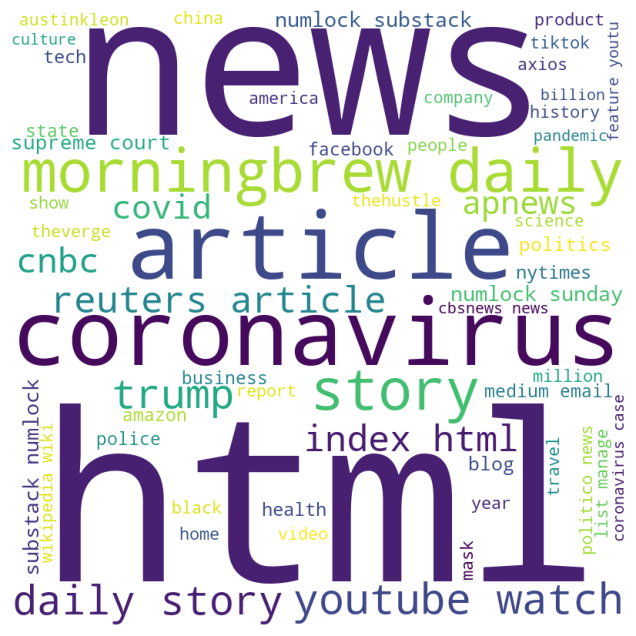

In [19]:
#Plotting a wordcloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "white", max_words = 1000, min_font_size = 20, random_state = 42).generate(" ".join([" ".join(url) for url in df["url"]]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [21]:
# Join tokenized URLs for vectorization

tk_list = df["url"].apply(lambda x: " ".join(x))

In [22]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(tk_list).toarray()
y = df["is_spam"]

In [23]:
#Train/Test Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
#Fitting the model

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [25]:
#Predicting the model

y_pred = model.predict(X_test)

In [26]:
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Optimized Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Optimized Accuracy: 0.951
Optimized Confusion Matrix:
[[431   4]
 [ 19  20]]


In [27]:
#Optimizing the the hyperparameters

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']})

In [28]:
best_model = grid_search.best_estimator_
best_model

SVC(C=10)

In [29]:
y_pred = best_model.predict(X_test)
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Optimized Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Optimized Accuracy: 0.958
Optimized Confusion Matrix:
[[427   8]
 [ 12  27]]


In [30]:
#Saving the model

joblib.dump(best_model, "spam_classifier.pkl")

['spam_classifier.pkl']